# Example use case: Zero-age stellar luminosity function in binaries

In this notebook we compute the luminosity function of the zero-age main-sequence by running a population of binary stars using binary_c. 

Before you go through this notebook, you should look at notebook_luminosity_function.ipynb which is for the - conceptually more simple - single stars.

We start by loading in some standard Python modules and the binary_c module.


In [1]:
import os
import math
from binarycpython.utils.grid import Population

# help(Population) # Uncomment this line to see the public functions of this object

## Setting up the Population object
To set up and configure the population object we need to make a new instance of the `Population` object and configure it with the `.set()` function.

In our case, we only need to set the maximum evolution time to something short, because we care only about zero-age main sequence stars which have, by definition, age zero.

In [2]:
# Create population object
population = Population()

# If you want verbosity, set this before other things
population.set(verbosity=1)

# Setting values can be done via .set(<parameter_name>=<value>)
# Values that are known to be binary_c_parameters are loaded into bse_options.
# Those that are present in the default grid_options are set in grid_options
# All other values that you set are put in a custom_options dict
population.set(
    # binary_c physics options
    max_evolution_time=0.1,  # maximum stellar evolution time in Myr
 )

# We can access the options through 
print("verbosity is", population.grid_options['verbosity'])

adding: max_evolution_time=0.1 to BSE_options
verbosity is 1


## Adding grid variables
The main purpose of the Population object is to handle the population synthesis side of running a set of stars. The main method to do this with binarycpython, as is the case with Perl binarygrid, is to use grid variables. These are loops over a predefined range of values, where a probability will be assigned to the systems based on the chosen probability distributions.

Usually we use either 1 mass grid variable, or a trio of mass, mass ratio and period (other notebooks cover these examples). We can, however, also add grid sampling for e.g. eccentricity, metallicity or other parameters. 

To add a grid variable to the population object we use `population.add_grid_variable`

In [3]:
# help(population.add_grid_variable)

All the distribution functions that we can use are stored in the `binarycpython.utils.distribution_functions` or `binarycpython/utils/distribution_functions.py` on git. If you uncomment the help statement below you can see which functions are available now:

In [4]:
import binarycpython.utils.distribution_functions
# help(binarycpython.utils.distribution_functions)

First let us set up some global variables that will be useful throughout. 
* The resolution is the number of stars we simulate in our model population.
* The massrange is a list of the min and max masses
* The total_probability is the theoretical integral of a probability density function, i.e. 1.0.
* The binwidth sets the resolution of the final distribution. If set to 0.5, the bins in log*L* are 0.5dex wide.

In [5]:
# Set resolution and mass range that we simulate
resolution = {"M_1": 40} # start with resolution = 10, and increase later if you want "more accurate" data
massrange = (0.07, 100.0) # we work with stars of mass 0.07 to 100 Msun
total_probability = 1.0 # theoretical integral of the mass probability density function over all masses    
# distribution binwidths : 
# (log10) luminosity distribution
binwidth = { 'luminosity' : 1.0 }

The next cell contains an example of adding the mass grid variable, sampling the phase space in linear mass *M*_1.

In [6]:
# Set up the binary grid in "cubic" M1 - M2=q*M1 - log10 period space

population = Population()

# resolution on each side of the cube, with more stars for the primary mass
nres = 10
resolution = {"M_1": 2*nres,
              "q": nres,
              "per": nres}

massrange = [0.07,100]
logperrange = [0.15, 5.5]

population.add_grid_variable(
    name="lnm1",
    longname="Primary mass",
    valuerange=massrange,
    resolution="{}".format(resolution["M_1"]),
    spacingfunc="const(math.log({min}), math.log({max}), {res})".format(min=massrange[0],max=massrange[1],res=resolution["M_1"]),
    precode="M_1=math.exp(lnm1)",
    probdist="three_part_powerlaw(M_1, 0.1, 0.5, 1.0, 150, -1.3, -2.3, -2.3)*M_1",
    dphasevol="dlnm1",
    parameter_name="M_1",
    condition="",  # Impose a condition on this grid variable. Mostly for a check for yourself
)

# Mass ratio
population.add_grid_variable(
     name="q",
     longname="Mass ratio",
     valuerange=["0.1/M_1", 1],
     resolution="{}".format(resolution['q']),
     spacingfunc="const({}/M_1, 1, {})".format(massrange[0],resolution['q']),
     probdist="flatsections(q, [{{'min': {}/M_1, 'max': 1.0, 'height': 1}}])".format(massrange[0]),
     dphasevol="dq",
     precode="M_2 = q * M_1",
     parameter_name="M_2",
     condition="",  # Impose a condition on this grid variable. Mostly for a check for yourself
 )

# Orbital period
population.add_grid_variable(
    name="log10per", # in days
    longname="log10(Orbital_Period)",
    valuerange=[0.15, 5.5],
    resolution="{}".format(resolution["per"]),
    spacingfunc="const({}, {}, {})".format(logperrange[0],logperrange[1],resolution["per"]),
    precode="""orbital_period = 10.0 ** log10per
sep = calc_sep_from_period(M_1, M_2, orbital_period)
sep_min = calc_sep_from_period(M_1, M_2, 10**{})
sep_max = calc_sep_from_period(M_1, M_2, 10**{})""".format(logperrange[0],logperrange[1]),
    probdist="sana12(M_1, M_2, sep, orbital_period, sep_min, sep_max, math.log10(10**{}), math.log10(10**{}), {})".format(logperrange[0],logperrange[1],-0.55),
    parameter_name="orbital_period",
    dphasevol="dlog10per",
 )

## Setting logging and handling the output
By default, binary_c will not output anything (except for 'SINGLE STAR LIFETIME'). It is up to us to determine what will be printed. We can either do that by hardcoding the print statements into `binary_c` (see documentation binary_c) or we can use the custom logging functionality of binarycpython (see notebook `notebook_custom_logging.ipynb`), which is faster to set up and requires no recompilation of binary_c, but is somewhat more limited in its functionality. For our current purposes, it works perfectly well.

After configuring what will be printed, we need to make a function to parse the output. This can be done by setting the parse_function parameter in the population object (see also notebook `notebook_individual_systems.ipynb`). 

In the code below we will set up both the custom logging and a parse function to handle that output.

In [7]:
# Create custom logging statement
#
# we check that the model number is zero, i.e. we're on the first timestep (stars are born on the ZAMS)
# we make sure that the stellar type is <= MAIN_SEQUENCE, i.e. the star is a main-sequence star
# we also check that the time is 0.0 (this is not strictly required, but good to show how it is done)
#
# The 
#
# The Printf statement does the outputting: note that the header string is ZERO_AGE_MAIN_SEQUENCE_STARn
#
# where:
#
# n = PRIMARY    = 0 is star 0 (primary star)
# n = SECONDARY  = 1 is star 1 (secondary star)
# n = UNRESOLVED = 2 is the unresolved system (both stars added)

PRIMARY = 0
SECONDARY = 1
UNRESOLVED = 2

custom_logging_statement = """
// select ZAMS
if(stardata->model.model_number == 0 &&
   stardata->model.time == 0)
{
    // loop over the stars individually (equivalent to a resolved binary) 
    Foreach_star(star)
    {
        // select main-sequence stars
        if(star->stellar_type <= MAIN_SEQUENCE)
        {
            /* Note that we use Printf - with a capital P! */
           Printf("ZERO_AGE_MAIN_SEQUENCE_STAR%d %30.12e %g %g %g %g\\n",
                  star->starnum,
                  stardata->model.time, // 1
                  stardata->common.zero_age.mass[0], // 2
                  star->mass, // 3
                  star->luminosity, // 4
                  stardata->model.probability // 5
           );
        }
    }
    
    // unresolved MS-MS binary
    if(stardata->star[0].stellar_type <= MAIN_SEQUENCE &&
       stardata->star[1].stellar_type <= MAIN_SEQUENCE) 
    {
        Printf("ZERO_AGE_MAIN_SEQUENCE_STAR%d %30.12e %g %g %g %g\\n",
                  2,
                  stardata->model.time, // 1
                  stardata->common.zero_age.mass[0] + stardata->common.zero_age.mass[1], // 2
                  stardata->star[0].mass + stardata->star[1].mass, // 3
                  stardata->star[0].luminosity + stardata->star[1].luminosity, // 4
                  stardata->model.probability // 5
           );
    }
}
"""

population.set(
    C_logging_code=custom_logging_statement
)


The parse function must now catch lines that start with "ZERO_AGE_MAIN_SEQUENCE_STAR" and process the associated data.

In [8]:
# import the bin_data function so we can construct finite-resolution probability distributions
# import the datalinedict to make a dictionary from each line of data from binary_c
from binarycpython.utils.functions import bin_data,datalinedict
import re

def parse_function(self, output):
    """
    Example parse function
    """
    
    # list of the data items
    parameters = ["header", "time", "zams_mass", "mass", "luminosity", "probability"]
    
    # Loop over the output.
    for line in output.splitlines():
        
        # check if we match a ZERO_AGE_MAIN_SEQUENCE_STAR
        match = re.search('ZERO_AGE_MAIN_SEQUENCE_STAR(\d)',line) 
        if match:
            nstar = match.group(1) 
            #print("matched star",nstar)

            # obtain the line of data in dictionary form 
            linedata = datalinedict(line,parameters)

            # bin the log10(luminosity) to the nearest 0.1dex
            binned_log_luminosity = bin_data(math.log10(linedata['luminosity']),
                                             binwidth['luminosity'])
            
            # append the data to the results_dictionary 
            self.grid_results['luminosity distribution'][int(nstar)][binned_log_luminosity] += linedata['probability'] 
            
            #print (self.grid_results)
    
    # verbose reporting
    #print("parse out results_dictionary=",self.grid_results)
    
# Add the parsing function
population.set(
    parse_function=parse_function,
)

## Evolving the grid
Now that we configured all the main parts of the population object, we can actually run the population! Doing this is straightforward: `population.evolve()`

This will start up the processing of all the systems. We can control how many cores are used by settings `amt_cores`. By setting the `verbosity` of the population object to a higher value we can get a lot of verbose information about the run, but for now we will set it to 0.

There are many grid_options that can lead to different behaviour of the evolution of the grid. Please do have a look at those: [grid options docs](https://ri0005.pages.surrey.ac.uk/binary_c-python/grid_options_descriptions.html), and try  

In [9]:
# set number of threads
population.set(
    # verbose output is not required    
    verbosity=1,
    # set number of threads (i.e. number of CPU cores we use)
    amt_cores=4,
    )

# Evolve the population - this is the slow, number-crunching step
print("Running the population now, this may take a little while...")
analytics = population.evolve()  
print("Done population run!")

# Show the results (debugging)
# print (population.grid_results)

adding: amt_cores=4 to grid_options
Running the population now, this may take a little while...
Creating and loading custom logging functionality
Generating grid code
Generating grid code
Constructing/adding: lnm1
Constructing/adding: q
Constructing/adding: log10per
Saving grid code to grid_options
Writing grid code to /tmp/binary_c_python/binary_c_grid_0fa295ee5c76444bace8fd0ee17a3e11.py
Loading grid code function from /tmp/binary_c_python/binary_c_grid_0fa295ee5c76444bace8fd0ee17a3e11.py
Grid code loaded
Grid has handled 2000 stars
with a total probability of 0.6495098935846658
Total starcount for this run will be: 2000


[2021-09-10 15:14:08,077 DEBUG    Process-2] --- Setting up processor: process-0[2021-09-10 15:14:08,080 DEBUG    Process-3] --- Setting up processor: process-1[2021-09-10 15:14:08,086 DEBUG    MainProcess] --- setting up the system_queue_filler now

[2021-09-10 15:14:08,084 DEBUG    Process-4] --- Setting up processor: process-2

[2021-09-10 15:14:08,117 DEBUG    Process-5] --- Setting up processor: process-3

Process 1 started at 2021-09-10T15:14:08.119437.	Using store memaddr <capsule object "STORE" at 0x7f351ff53810>Process 0 started at 2021-09-10T15:14:08.126435.	Using store memaddr <capsule object "STORE" at 0x7f351ff539f0>
Process 2 started at 2021-09-10T15:14:08.138353.	Using store memaddr <capsule object "STORE" at 0x7f351ff539f0>



Process 3 started at 2021-09-10T15:14:08.186492.	Using store memaddr <capsule object "STORE" at 0x7f351ff53810>
Generating grid code
Generating grid code
Constructing/adding: lnm1
Constructing/adding: q
Constructing/adding: log10per
Saving grid code to grid_options
Writing grid code to /tmp/binary_c_python/binary_c_grid_0fa295ee5c76444bace8fd0ee17a3e11.py
Loading grid code function from /tmp/binary_c_python/binary_c_grid_0fa295ee5c76444bace8fd0ee17a3e11.py
Grid code loaded
624/2000  31.2% complete 15:14:12 ETA=   11.1s tpr=8.05e-03 ETF=15:14:23 mem:800.5MB625/2000  31.2% complete 15:14:12 ETA=   11.1s tpr=8.04e-03 ETF=15:14:23 mem:800.5MB
626/2000  31.3% complete 15:14:12 ETA=   11.1s tpr=8.05e-03 ETF=15:14:23 mem:800.5MB

713/2000  35.6% complete 15:14:17 ETA=    1.3m tpr=6.00e-02 ETF=15:15:34 mem:547.8MB
728/2000  36.4% complete 15:14:22 ETA=    7.1m tpr=3.37e-01 ETF=15:21:30 mem:548.1MB
743/2000  37.1% complete 15:14:27 ETA=    7.0m tpr=3.34e-01 ETF=15:21:26 mem:549.5MB
759/2000  

[2021-09-10 15:16:25,175 DEBUG    MainProcess] --- Signaling stop to processes


1003/2000  50.1% complete 15:16:26 ETA=   11.2m tpr=6.76e-01 ETF=15:27:40 mem:563.0MB
1015/2000  50.8% complete 15:16:32 ETA=    7.6m tpr=4.65e-01 ETF=15:24:10 mem:563.0MB
1025/2000  51.2% complete 15:16:37 ETA=    8.1m tpr=5.01e-01 ETF=15:24:45 mem:563.0MB
1033/2000  51.6% complete 15:16:42 ETA=   10.7m tpr=6.65e-01 ETF=15:27:26 mem:563.0MB
1040/2000  52.0% complete 15:16:47 ETA=   12.1m tpr=7.55e-01 ETF=15:28:52 mem:563.5MB
1048/2000  52.4% complete 15:16:53 ETA=   11.8m tpr=7.45e-01 ETF=15:28:42 mem:563.5MB
1057/2000  52.9% complete 15:16:59 ETA=    9.1m tpr=5.78e-01 ETF=15:26:03 mem:563.6MB
1062/2000  53.1% complete 15:17:04 ETA=   15.7m tpr=1.01e+00 ETF=15:32:47 mem:564.4MB
1069/2000  53.5% complete 15:17:09 ETA=   12.4m tpr=7.97e-01 ETF=15:29:31 mem:564.9MB
1077/2000  53.9% complete 15:17:15 ETA=   11.5m tpr=7.46e-01 ETF=15:28:44 mem:565.0MB
1085/2000  54.2% complete 15:17:20 ETA=   10.0m tpr=6.55e-01 ETF=15:27:20 mem:565.0MB
1091/2000  54.5% complete 15:17:26 ETA=   13.8m tpr=9.

[2021-09-10 15:27:22,382 DEBUG    Process-5] --- Process-3 is finishing.


Process 3 finished:
	generator started at 2021-09-10T15:14:08.117391, done at 2021-09-10T15:27:22.400722 (total: 794.283331s of which 792.6935975551605s interfacing with binary_c).
	Ran 499 systems with a total probability of 0.17005450973840136.
	This thread had 0 failing systems with a total probability of 0.
	Skipped a total of 0 systems because they had 0 probability


[2021-09-10 15:27:22,435 DEBUG    Process-5] --- Process-3 is finished.
[2021-09-10 15:27:22,480 DEBUG    Process-3] --- Process-1 is finishing.


Process 1 finished:
	generator started at 2021-09-10T15:14:08.080367, done at 2021-09-10T15:27:22.505288 (total: 794.424921s of which 793.1943278312683s interfacing with binary_c).
	Ran 474 systems with a total probability of 0.15740832333567983.
	This thread had 0 failing systems with a total probability of 0.
	Skipped a total of 0 systems because they had 0 probability


[2021-09-10 15:27:22,531 DEBUG    Process-3] --- Process-1 is finished.
[2021-09-10 15:27:22,846 DEBUG    Process-2] --- Process-0 is finishing.


Process 0 finished:
	generator started at 2021-09-10T15:14:08.077117, done at 2021-09-10T15:27:22.851971 (total: 794.774854s of which 793.4976091384888s interfacing with binary_c).
	Ran 507 systems with a total probability of 0.16018641159091498.
	This thread had 0 failing systems with a total probability of 0.
	Skipped a total of 0 systems because they had 0 probability


[2021-09-10 15:27:22,872 DEBUG    Process-2] --- Process-0 is finished.
[2021-09-10 15:27:22,976 DEBUG    Process-4] --- Process-2 is finishing.


Process 2 finished:
	generator started at 2021-09-10T15:14:08.084369, done at 2021-09-10T15:27:22.981706 (total: 794.897337s of which 793.4600214958191s interfacing with binary_c).
	Ran 520 systems with a total probability of 0.1618606489196724.
	This thread had 0 failing systems with a total probability of 0.
	Skipped a total of 0 systems because they had 0 probability


[2021-09-10 15:27:22,986 DEBUG    Process-4] --- Process-2 is finished.


Population-0fa295ee5c76444bace8fd0ee17a3e11 finished! The total probability was: 0.6495098935846686. It took a total of 795.1383104324341s to run 2000 systems on 4 cores
There were no errors found in this run.
Done population run!


After the run is complete, some technical report on the run is returned. I stored that in `analytics`. As we can see below, this dictionary is like a status report of the evolution. Useful for e.g. debugging.

In [12]:
print(analytics)

{'population_name': '0fa295ee5c76444bace8fd0ee17a3e11', 'evolution_type': 'grid', 'failed_count': 0, 'failed_prob': 0, 'failed_systems_error_codes': [], 'errors_exceeded': False, 'errors_found': False, 'total_probability': 0.6495098935846686, 'total_count': 2000, 'start_timestamp': 1631283248.057525, 'end_timestamp': 1631284043.1958354, 'total_mass_run': 41112.220964392276, 'total_probability_weighted_mass_run': 0.6452116023479681, 'zero_prob_stars_skipped': 0}


[None]

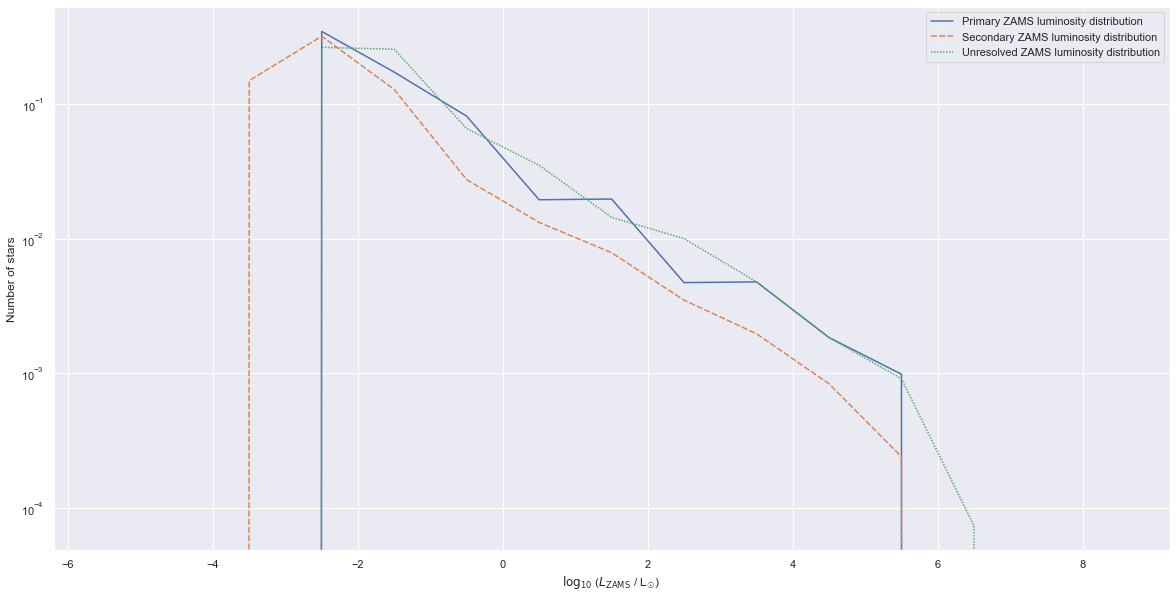

In [13]:
# make a plot of the luminosity distribution using Seaborn and Pandas
import seaborn as sns
import pandas as pd
from binarycpython.utils.functions import pad_output_distribution

# set the figure size (for a Jupyter notebook in a web browser) 
sns.set( rc = {'figure.figsize':(20,10)} )

titles = { 0 : "Primary",
           1 : "Secondary",
           2 : "Unresolved" }

# choose to plot the 
# PRIMARY, SECONDARY or UNRESOLVED
nstar = UNRESOLVED

plots = {}

# pad the distribution with zeros where data is missing
for n in range(0,3):
    pad_output_distribution(population.grid_results['luminosity distribution'][n],
                            binwidth['luminosity'])
    plots[titles[n] + ' ZAMS luminosity distribution'] = population.grid_results['luminosity distribution'][n]

# make pandas dataframe from our sorted dictionary of data
plot_data = pd.DataFrame.from_dict(plots)

# make the plot
p = sns.lineplot(data=plot_data)
p.set_xlabel("$\log_{10}$ ($L_\mathrm{ZAMS}$ / L$_{☉}$)")
p.set_ylabel("Number of stars")
p.set(yscale="log")